# Projet 10 : Détectez des faux billets avec Python 💶 💸 

In [1]:
# Librairies de calcul:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as st
from scipy.stats import t, shapiro
import statsmodels
import sklearn as sk
from sklearn import preprocessing

# Libairies de representation graphique:
import matplotlib.pyplot as plt
import seaborn as sns

# Pour la regression lineaire:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression

# Pour la regression logistique:
from statsmodels.api import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score
from sklearn.linear_model import LogisticRegression

# Pour le K-mean:
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn import metrics

# Pour le Knn:
from sklearn import neighbors

# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools


In [2]:
# Fonctions

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center',
                                 rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(16,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    # critère de Kaiser
    p = len(Billet_df.columns)
    kaiser = 100 / p
        
    plt.figure(figsize=(15, 10))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.axhline(y=kaiser, color='red', linestyle='--')
    plt.xticks(np.arange(len(scree))+1)
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres", fontsize=16, fontweight='bold')
    plt.show(block=False)
    scree_cum = (pca.explained_variance_ratio_*100).cumsum()
    scree_cum = pd.DataFrame(data=scree_cum, index=np.arange(len(scree))+1, columns=['Cumul de variance expliquée']).T
    print(scree_cum)

#Fonction de selection automatique du modele reg lineaire
def backward_selected(data, response):
        remaining = set(data._get_numeric_data().columns)
        if response in remaining:
            remaining.remove(response)
        cond = True
        while remaining and cond:
            formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
            print('_______________________________')
            print(formula)
            model = smf.ols(formula, data).fit()
            score = model.pvalues[1:]
            toRemove = score[score == score.max()]
            if toRemove.values > 0.05:
                print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
                remaining.remove(toRemove.index[0])
            else:
                cond = False
                print('is the final model !')
            print('')
        print(model.summary())
        return model
    
#Fonction de selection automatique du modele reg logistique
def my_backward_selected_logistic(data, response):
    """Logistic regression model designed by backward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels logistic regression model
           with an intercept
           selected by backward selection
           evaluated by parameters p-value
    """
    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response, ' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.logit(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value:', round(toRemove.values[0], 3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model!')
        print('')
    print(model.summary())

    return model

# Projet 10 : Détectez des faux billets avec Python 💶 💸 

In [3]:
# Import des donnees:
billet_df = pd.read_csv("billets.csv", sep = ';',)

# Analyse exploratoire

In [4]:
billet_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<b> Description variables :</b>
- is_genuine : nature du billet (vrai ou faux) ;
- diagonal : la diagonale du billet (en mm) ;
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ;
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
- length : la longueur du billet (en mm).
###### Source : Organisation nationale de lutte contre le faux-monnayage (ONCFM)

In [5]:
billet_df.info()
billet_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:
billet_df['is_genuine'].unique()

array([ True, False])

In [7]:
#On compte 1000 billets vrais pour 500 faux billets dans nos données. 
billet_df['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [8]:
print(len(billet_df) - len(billet_df.drop_duplicates()), 'doublon') # Aucun doublon

0 doublon


Les types de données sont ceux attendus, pas de doublon dans les données, et a première vue pas de valeur abbérantes.   
Cependant, il y a des valeurs manquantes sur la variable 'margin_low' (marge entre le bord inférieur du billet et l'image).

In [9]:
#Identification des valeurs manquantes
print(billet_df.isna().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


Comme demandé dans le projet, nous allons faire une régression linéaire pour estimer les valeurs manquantes.

#  Traitement des valeurs manquantes

/var/folders/7p/qmwkn84d5f79vzff9sdp0zq00000gn/T/ipykernel_56096/3953886799.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(matrix, dtype=np.bool))


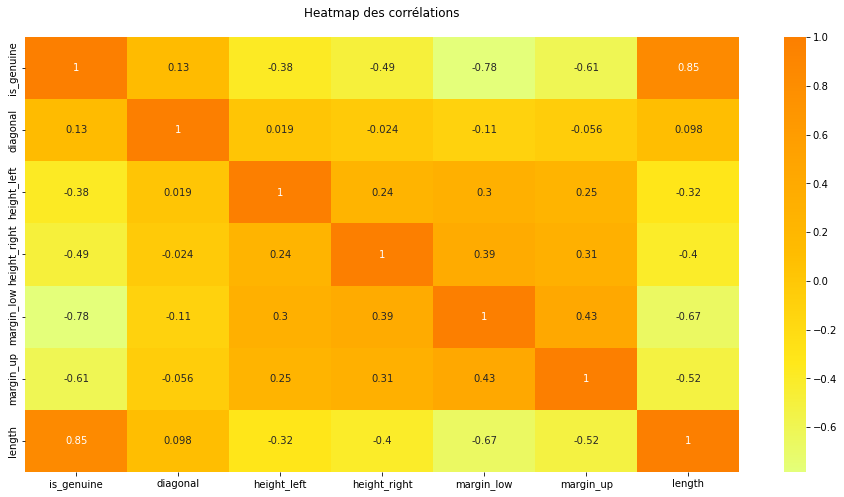

In [10]:
matrix = billet_df.corr(method='pearson')
#.drop(columns="is_genuine")
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(16, 8))
sns.heatmap(matrix, cmap='Wistia',annot=True)
plt.title("Heatmap des corrélations", pad=20)
plt.show()

Les variables is_genuine, lenght et margin_up semblent être corrélées avec la variable margin_low pour laquelle on veut traiter les valeurs manquantes.

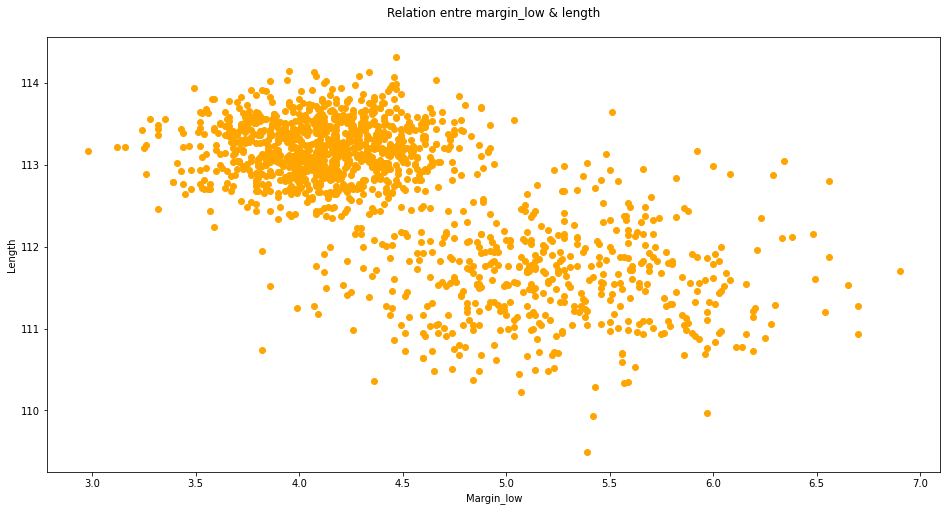

In [11]:
# Visualisation de la relation entre margin_low & length
plt.figure(figsize=(16, 8))
plt.scatter(billet_df.margin_low,billet_df.length, c='orange')
plt.title("Relation entre margin_low & length", pad=20)
plt.xlabel('Margin_low') 
plt.ylabel('Length')
plt.show()

Ce nuage de points nous fait penser à un alignement selon une forme qui n'est pas très loin d'une droite.

# Régression linéaire simple (R2 = 0.44)

In [12]:
# Separation des donnees manquantes des donnees :
df_sans_nan=billet_df.dropna()
df_nan = billet_df[billet_df.isnull().any(axis=1)]

In [13]:
#Regression lineaire
reg_simp = smf.ols('margin_low ~ length', data=df_sans_nan).fit()
print(reg_simp.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Fri, 16 Jun 2023   Prob (F-statistic):          8.98e-189
Time:                        17:36:51   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5960      1.670     36.881      0.0

Les p-valeurs sont inférieures à 5 %. À un niveau de test de 5 %, on rejette donc l'hypothèse selon laquelle le coefficient est égal à 0 : les paramètres sont donc significativement différents de 0. Ici, on voit que la variable length est significative.
Quant au  𝑅2 , il est de l'ordre de 0.44. Ce n'est pas très élevé, mais ceci est du à la dispersion du nuage de points originel.

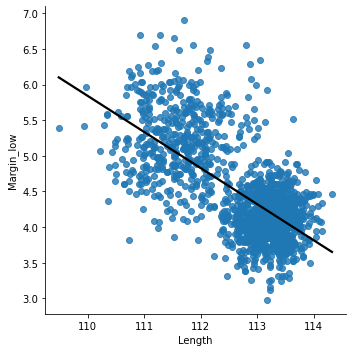

<Figure size 1152x576 with 0 Axes>

In [14]:
#visualisation de la droite de regression
ax = sns.lmplot(x="length", y="margin_low", data=df_sans_nan, ci=None, line_kws={'color':'black'})
plt.figure(figsize=(16, 8))
ax.set(xlabel='Length', ylabel='Margin_low')
plt.show()

On peut également représenter les valeurs ajustées en fonction des valeurs observées :

/var/folders/7p/qmwkn84d5f79vzff9sdp0zq00000gn/T/ipykernel_56096/1614791741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sans_nan['margin_low_ajust_s'] = reg_simp.predict()


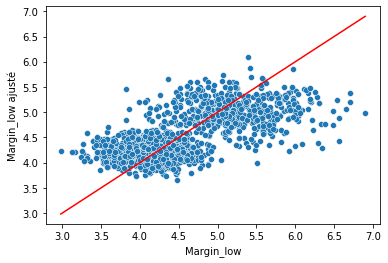

In [15]:
df_sans_nan['margin_low_ajust_s'] = reg_simp.predict()

X_plot = [df_sans_nan['margin_low'].min(), df_sans_nan['margin_low'].max()]

ax = sns.scatterplot(x="margin_low", y="margin_low_ajust_s", data=df_sans_nan)
ax.set(xlabel='Margin_low', ylabel='Margin_low ajusté')
plt.plot(X_plot, X_plot, color='r')
plt.show()

La droite qui s'affiche est la première bissectrice. Le modèle n'est pas parfait, les valeurs réelles et les valeurs ajustées ne sont pas égales.
Les résidus semblemnt avoir une dispersion à peu prés constante.

In [16]:
# representation des résidus du modele
df_sans_nan['residu_s'] = reg_simp.resid

/var/folders/7p/qmwkn84d5f79vzff9sdp0zq00000gn/T/ipykernel_56096/2833741984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sans_nan['residu_s'] = reg_simp.resid


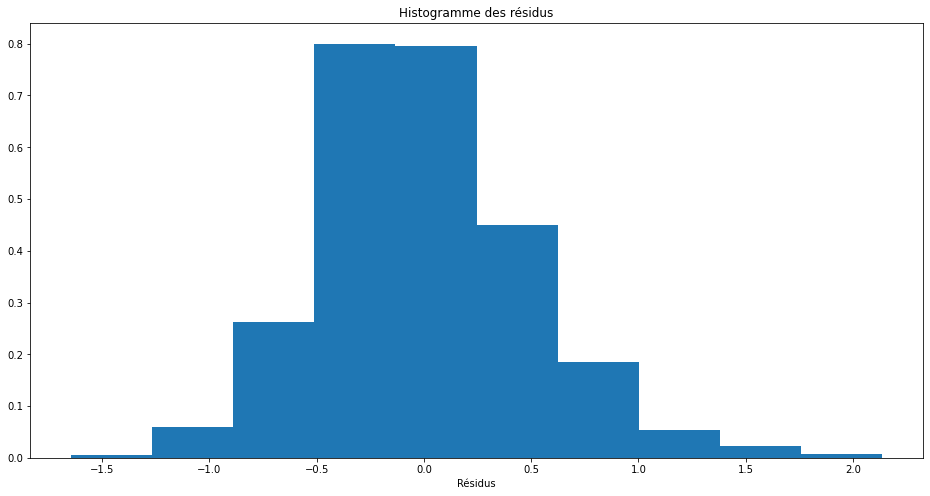

In [17]:
#graphique 
plt.figure(figsize=(16, 8))
plt.hist(df_sans_nan['residu_s'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

L'allure de l'histogramme est assez classique : centrée et à peu près symétrique.

# Régression linéaire multiple (R2 = 0.61)

La régression linéaire ne fait intervenir qu’une seule variable explicative : on veut créer un modèle qui estime "Margin_Low" en fct des autres variables.
- niveau de test alpha = 0.05

In [18]:
# Separation des donnees manquantes des donnees :
df_sans_nan=billet_df.dropna()
df_nan = billet_df[billet_df.isnull().any(axis=1)]

In [19]:
df_sans_nan

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [20]:
# Creation de X_train et Y_train:
x_train = df_sans_nan.drop("margin_low", axis=1)
y_train = df_sans_nan["margin_low"]


# Regression lineaire sklearn:
reg_lin = LinearRegression() # instanciation
model_reg_lin = reg_lin.fit(x_train, y_train) #Entrainement
model_reg_lin.score(x_train,y_train) #score 

0.6168760755671029

Le r² ou coefficient de détermination est une mesure de la qualité de la prédiction linéaire, ici d'environ 62%, il n'est pas de bonne qualité, puisque l'on recherche plus de 90%..  
NB : Plus le résultat tend vers 0 plus le nuage de points est dispersé autour de la droite, a l'inverse, plus le résultat est proche de 1 plus le nuage de points se ressert sur la droite.

In [21]:
# Predictions sklearn :
x_reg = df_sans_nan[["is_genuine","diagonal","height_left","height_right", "margin_up", "length"]]
df_sans_nan["margin_low_pred"] = reg_lin.predict(x_reg)

/var/folders/7p/qmwkn84d5f79vzff9sdp0zq00000gn/T/ipykernel_56096/3519533556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sans_nan["margin_low_pred"] = reg_lin.predict(x_reg)


In [22]:
print("Intercept:", model_reg_lin.intercept_)
print("Coéfficients:", model_reg_lin.coef_)

Intercept: 2.8668228920543672
Coéfficients: [-1.14059676 -0.0130159   0.02829069  0.02674982 -0.21284432 -0.00388299]


<b> La valeur d'intercept </b> est la valeur moyenne estimée de notre variable dépendante lorsque toutes nos valeurs de variables indépendantes sont égales à 0.    
<b>Les coefficients de régression</b> représentent le changement moyen de la variable de réponse pour une unité de changement dans la variable prédictive tout en maintenant d’autres prédicteurs dans le modèle constant. Ici le coefficient indique que si la longueur ('length') change de 1mm, on peut s'attendre à ce que l'estimation 'margin_low' diminue de 0,003 mm en moyenne.


## Validation du modèle
Après avoir construit le modèle, il est important de valider ses performances. 

In [23]:
# Instanciation:
model_smf = smf.ols(formula='margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data = df_sans_nan)
# "margin_low ~is_genuine+ diagonal + height_left + height_right + margin_up + length"
# Calculs:
res_lin_smf = model_smf.fit()
print(res_lin_smf.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Fri, 16 Jun 2023   Prob (F-statistic):          4.75e-299
Time:                        17:36:53   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

Certains coefficients ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %. Nous allons donc retirer les variables non significatives une à une, jusqu'à ce que p-valeur < 0.05 pour tous les paramètres.

In [24]:
# Instanciation:
model_smf2 = smf.ols('margin_low~is_genuine+margin_up', data = df_sans_nan)
# "margin_low ~is_genuine+ diagonal + height_left + height_right + margin_up + length"
# Calculs:
res_lin_smf2 = model_smf2.fit()
print(res_lin_smf2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Fri, 16 Jun 2023   Prob (F-statistic):          1.24e-304
Time:                        17:36:53   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

## Analyse des indicateurs du modèle 

In [25]:
# Coefficient de détermination (𝑅2 ou R-squared)

Le score R² explique dans quelle mesure la variance totale de la variable dépendante peut être réduite en utilisant la régression des moindres carrés.

Le coefficient de détermination (𝑅2) est de 0.617 et le 𝑅2 ajusté est de 0.616. Ainsi, l’erreur de prévision est réduite d’environ 61% en utilisant la régression (par rapport à l'utilisation de la moyenne des valeurs observées comme valeur prédite).
  

In [26]:
# Prob (F-statistic)

Prob (F-statistic) est inférieur à 0,05 : il y a au moins une des deux variables significativement liée à la variable 'margin_low'.

NB : L'hypothèse nulle du test de Fisher est que "tous les coefficients de régression sont égaux à zéro". Prob(F-statistics) décrit la probabilité que l'hypothèse nulle soit vraie. Ici, elle est très faible et inférieure au seuil alpha 5 % (ou 1 %), on rejette l'hypothèse nulle, dans l'ensemble, les régressions sont significatives.     

In [27]:
# Log-Likelihood

La valeur de log-vraisemblance est une mesure de l'ajustement du modèle avec les données. Plus cette valeur est élevée, plus le modèle s'ajuste aux données. (ici = -774.73)

In [28]:
# AIC (Critère d'Akaike) et BIC (Critère de Schwarz)

Sont des critères de robustesse du modèle (compromis entre l'ajustement du modèle -on privilégie une faible variance résiduelle- et la parcimonie du modèle -on privilégie alors un faible nombre de variables explicatives-). L'objectif est de minimiser ces valeurs. Nous constatons que AIC et BIC du dernier modèle choisi sont moins élevés que dans le premier modèle (moins de variables explicatives sélectionnées).

In [29]:
# Cond. No.

Un résultat élevé indique qu'il existe une multicolinéarité possible dans l'ensemble de données (ici=65.0).

In [30]:
# Omnibus

Omnibus décrit la normalité de la distribution des résidus en utilisant le skew et le kurtosis comme mesures. Un 0 indiquerait une normalité parfaite. Dans notre modèle prob(Omnibus) est de 0, il y a donc 0% de chances que les résidus soient normalement distribués.   
Ainsi, nous pouvons questionner la robustesse du modèle.  
En effet, si skew est très proche de 0 (=0.057), ce qui indique symétrie, kurtosis est supérieur à 3 (= 3.79). La distribution est donc étroite.

In [31]:
# Durbin-Watson

L'autocorrélation est la corrélation des erreurs (résidus) dans le temps. Durbin-Watson < 1.5, autocorrélation positive, l'hypothèse n'est pas satisfaite. 1.5 < Durbin-Watson < 2.5 pas d'autocorrélation, l'hypothèse est satisfaite. Durbin-Watson > 2.5, autocorrélation négative, l'hypothèse n'est pas satisfaite. 
Ici, il est de 2.041, il n'y a donc pas d'autocorrélation.

In [32]:
# Jarque-Béra

Similaire à Ominibus.  
H0 = les données suivent une loi normale.  
H1 = les données ne suivent pas une loi normale. 
Prob(JB) < 0.05 donc on rejette l'hypothèse de normalité au niveau de test 5%.

## Vérification des hypothèses

Avant de valider l'utilisation de la régression linéaire, nous devons vérifier plusieurs hypothèses afin de s'assurer que nous pouvons appliquer cette régression. Voici les hypothèses à vérifier :

- <b>Normalité :</b> Les erreurs résiduelles doivent être distribuées normalement. Cela signifie que les résidus doivent suivre une distribution normale avec une moyenne de zéro.
- <b>Homoscédasticité :</b> L'homoscédasticité signifie que la variance des erreurs résiduelles est constante à tous les niveaux de la variable prédite.
- <b>Multicolinéarité :</b> Cette hypothèse concerne la relation entre les variables prédictives (ou indépendantes) dans notre modèle de régression. Elle stipule qu'il ne devrait pas y avoir de forte corrélation linéaire entre les variables indépendantes.

### Test de la normalité des résidus
Le diagramme Quantile-Quantile est un outil graphique permettant d'évaluer la pertinence de l'ajustement d'une distribution donnée à un modèle théorique. On trace ici ce diagramme pour visualisé la normalité des résidus.

<Figure size 1152x576 with 0 Axes>

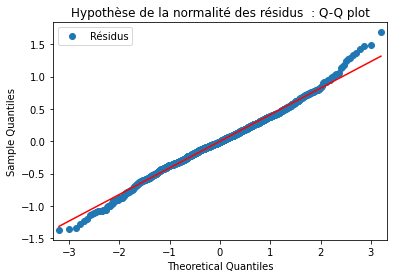

In [33]:
#Graphique QQ plot
plt.figure(figsize=(16, 8))
sm.qqplot(res_lin_smf2.resid, line='s', label="Résidus")
plt.title("Hypothèse de la normalité des résidus  : Q-Q plot")
plt.legend()
plt.show()

On observe que les points suivent globalement la droite qui passe par les quartiles. Les résidus semblent donc suivre la loi de normalité.

Pour tester la normalité on peut faire différents test : Shapiro-Wilk, Lilliefors, Anderson-Wilk ...

In [34]:
#Test de normalité Lilliefors
Lilliefors_statistic,Lilliefors_p_value=sm.stats.diagnostic.lilliefors(res_lin_smf2.resid,'norm')
Lilliefors_statistic,Lilliefors_p_value

(0.025413352396236544, 0.03328175682251635)

In [35]:
# Test de normalité des résidus (Shapiro-Wilk)
st.shapiro(res_lin_smf2.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

On peut voir qu'à travers le résultats du test l'hypothèse de normalité est remise en cause (p-value < 0.05).  

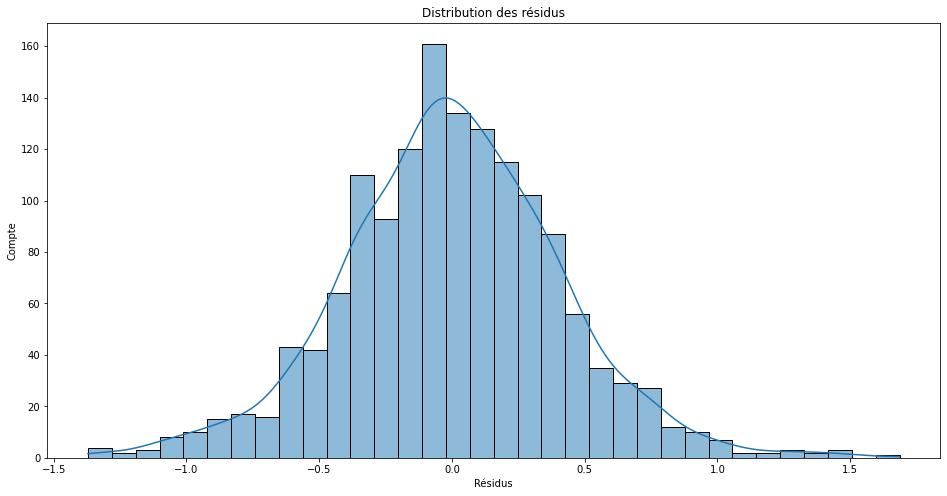

In [36]:
# Graphique:
plt.figure(figsize=(16, 8))
sns.histplot(res_lin_smf2.resid, kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

Néanmoins, l'observation des résidus ci-dessus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

In [37]:
# La moyenne des residus est nulle:
res_lin_smf2.resid.mean()

3.632850077570437e-15

-0.000000000000003 étant très proches de zéro, les résidus de la régression linéaire sont distribués selon une loi Normale de moyenne 0 (au moins grossièrement).

### Test de la Multicolinéarité des variables
On vérifie l'éventuelle colinéarité approchée des variables :

VIF (Variance Inflation Factor) signifie Facteur d'Inflation de la Variance. Au cours de l'analyse de régression, VIF évalue si les facteurs sont corrélés les uns aux autres (multi-colinéarité), ce qui pourrait influencer les autres facteurs et réduire la fiabilité du modèle.  

NB: Si un VIF est supérieur à 10, vous avez une multi-colinéarité élevée : la variation semblera plus grande et le facteur apparaîtra plus influent qu'il ne l'est. Si VIF est plus proche de 1, alors le modèle est beaucoup plus robuste, car les facteurs ne sont pas influencés par la corrélation avec d'autres facteurs.

In [38]:
# VIF model
variables1 = res_lin_smf2.model.exog
[variance_inflation_factor(variables1, i) for i in np.arange(1,variables1.shape[1])]

[1.5938854494007753, 1.5938854494007748]

Ici, les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

### Test de l’homoscédasticité

Text(0.5, 1.0, 'Homoscédasticité')

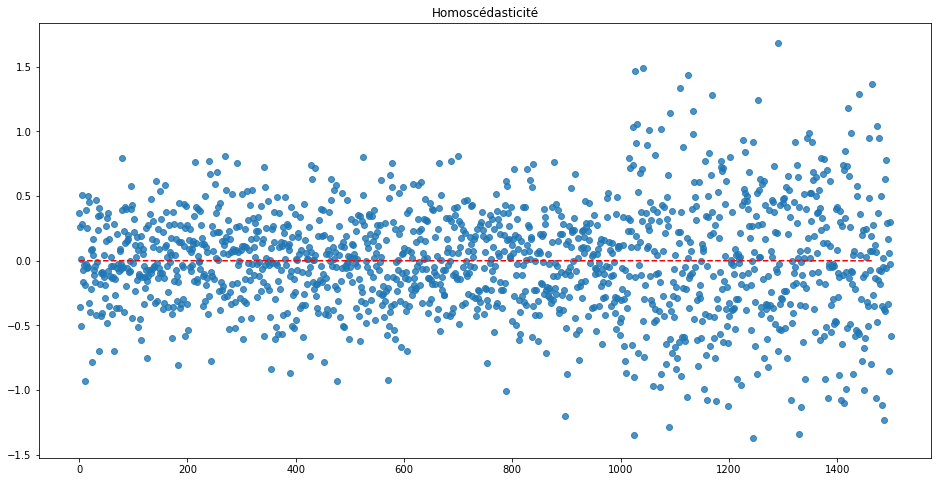

In [39]:
# Graphique:
plt.subplots(figsize=(16, 8))
plt.scatter(x=df_sans_nan.index, y=res_lin_smf2.resid, alpha=0.8)
plt.plot(np.repeat(0, len(df_sans_nan.index)+2), color="red", linestyle='--')
plt.title("Homoscédasticité")

La répartition semble aléatoire sur le graphique et répartie autour de 0.   

In [40]:
# Test Breusch Pagan (montre hétéroscedasticité)
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(res_lin_smf2.resid, variables1)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.203355911584878e-36


Si l'hypothèse de non-colinéarité n'est pas vérifiée, l'estimation du modèle est impossible alors que pour toutes les autres hypothèses, l'estimation est possible, mais donne un estimateur biaisé et/ou non efficace (à variance non-minimale). 

#### RAPPEL : Regression linéaire validé avec test d'hypothèses par analyse des résidus 
- 1 - Normalité de la distribution des résidus : ok (vérification par graphique + test)
- 2 - Homocédasticité : ok (vérification par graphique + test)
- 3 - Multicollinéarité : ok (VIF sur model res_lin_smf2 <10)

NB : Non-autocorrélation : ok (test de Durbin-Watson)

Notre modele n'est pas excellent, mais on peut l'utiliser pour prédictire et remplacer les valeurs manquantes de nos données, comme demandé dans le projet. (alternative : supression des 37 lignes, ou remplacer les valeurs manquantes par la moyenne de la variable).  

Pour essayer d'améliorer notre modèle nous allons faire l'étude des valeurs atypiques et/ou aberrantes.

## Prediction des données manquantes avant analyse des valeurs atypiques et/ou aberrantes

In [41]:
#df_sans_nan=billet_df.dropna()
#df_nan = billet_df[billet_df.isnull().any(axis=1)]

In [42]:
X1 = df_nan[['is_genuine','margin_up']]
Y1 = df_nan[['margin_low']]

In [43]:
# Prédiction des données manquantes
predictions1 = res_lin_smf2.predict(X1)

In [44]:
billets_pred1 = billet_df.copy()
billets_pred1.loc[billet_df['margin_low'].isnull(), 'margin_low'] = predictions1
billets_pred1.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [45]:
billets_pred1.loc[billet_df['margin_low'].isnull(), :]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.074248,3.25,112.79
99,True,171.93,104.07,104.18,4.097561,3.14,113.08
151,True,172.07,103.80,104.38,4.122994,3.02,112.93
197,True,171.45,103.66,103.80,3.995830,3.62,113.27
241,True,171.83,104.14,104.06,4.122994,3.02,112.36
251,True,171.80,103.26,102.82,4.137830,2.95,113.22
284,True,171.92,103.83,103.76,4.078487,3.23,113.29
334,True,171.85,103.70,103.96,4.127233,3.00,113.36
410,True,172.56,103.72,103.51,4.101800,3.12,112.95
413,True,172.30,103.66,103.50,4.093322,3.16,112.95


In [46]:
billets_pred1.info()
billets_pred1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482863,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659849,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


## Analyse des valeurs atypiques et/ou aberrantes
Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé analyses.

In [47]:
#Rappel reg
print(res_lin_smf2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Fri, 16 Jun 2023   Prob (F-statistic):          1.24e-304
Time:                        17:36:54   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

In [48]:
#Réalisation des tests à un seuil de 5%
alpha = 0.05

In [49]:
n = df_sans_nan.shape[0] # nb d'individus
p = 3 # nb de variable

In [50]:
d = {'obs':np.arange(1, n+1)}
analyses = pd.DataFrame(index = df_sans_nan.index, data = d)
#analyses['obs'].astype('float', inplace=True)

### Atypicité des observations

In [51]:
#Calcul des leviers 
analyses['levier'] = res_lin_smf2.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

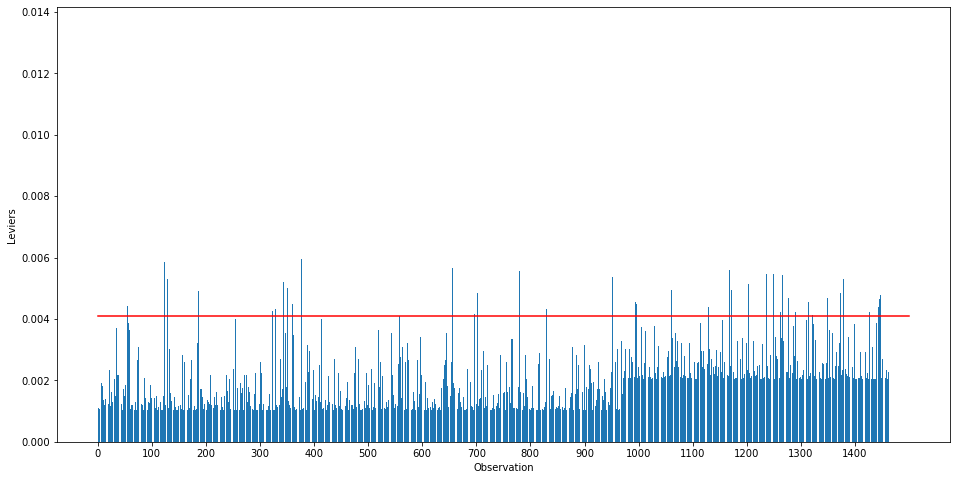

In [52]:
plt.figure(figsize=(16,8))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.show()

In [53]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
4,5,0.004748
48,49,0.007353
52,53,0.010647
54,55,0.004408
125,124,0.005865
...,...,...
1478,1442,0.005428
1479,1443,0.004406
1481,1445,0.004648
1483,1447,0.004796


Sur les variables explicatives, 67 observations sont considérées comme atypiques.

In [54]:
#Calculs des résidus studentisés (loi de Student à n-p-1 degrés de liberté)
analyses['rstudent'] = res_lin_smf2.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

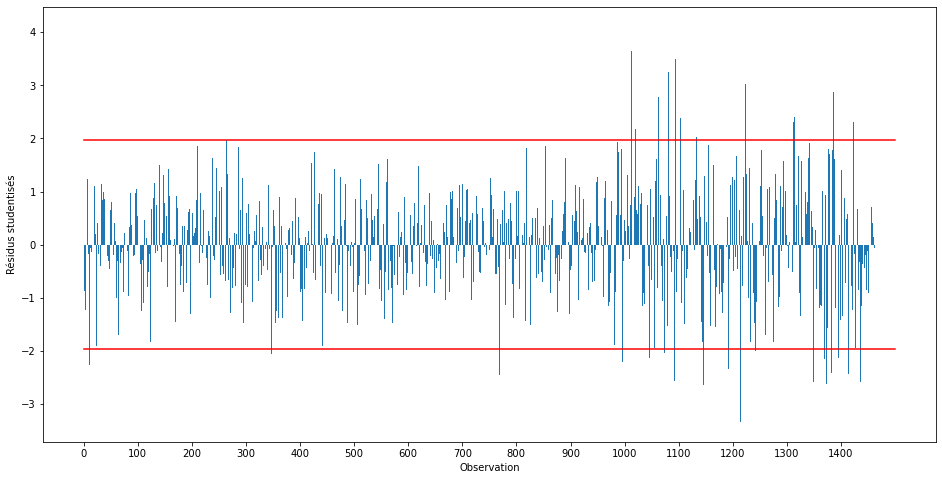

In [55]:
#graphique
plt.figure(figsize=(16,8))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [56]:
analyses.loc[(analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent), :]

,obs,levier,rstudent
10,11,0.001360,-2.260280
269,264,0.001906,1.965931
354,347,0.003559,-2.047795
390,383,0.001109,-2.114700
477,467,0.002227,-2.257411
...,...,...,...
1473,1437,0.002500,2.536322
1478,1442,0.005428,2.317452
1482,1446,0.002168,-2.709317
1486,1450,0.002053,-2.999746


Sur la variable à expliquer, 80 observations peuvent être considérées comme atypiques

### Influence des observations

En pratique, on ne retire que les observations atypiques ET influentes

In [57]:
# Déterminez la distance de Cook
influence = res_lin_smf2.get_influence().summary_frame()

In [58]:
# Le seuil de la distance de Cook est de n-p
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

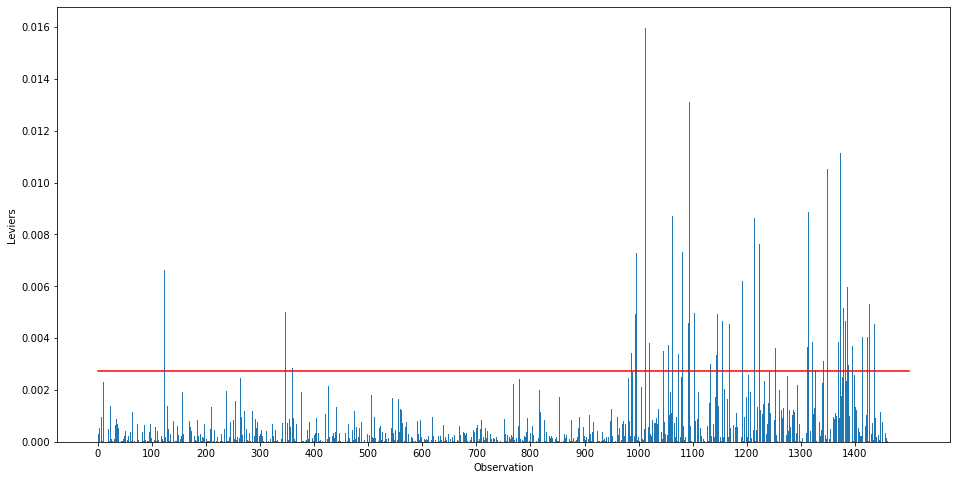

In [59]:
#graphique
plt.figure(figsize=(16,8))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [60]:
analyses.loc[analyses['dcooks'] > seuil_dcook, :]

,obs,levier,rstudent,dcooks
52,53,0.010647,-1.174185,0.004945
125,124,0.005865,-1.835525,0.006626
239,236,0.004408,1.876758,0.005198
341,334,0.003212,1.761293,0.003332
354,347,0.003559,-2.047795,0.004993
...,...,...,...,...
1478,1442,0.005428,2.317452,0.009770
1482,1446,0.002168,-2.709317,0.005315
1486,1450,0.002053,-2.999746,0.006170
1490,1454,0.004136,1.890304,0.004947


In [61]:
# Observations atypiques ET influentes

atyp_infl = analyses.loc[(analyses['dcooks'] > seuil_dcook) & 
             ((analyses['levier'] > seuil_levier) | 
              ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent))), :]

atyp_infl

,obs,levier,rstudent,dcooks
52,53,0.010647,-1.174185,0.004945
125,124,0.005865,-1.835525,0.006626
239,236,0.004408,1.876758,0.005198
354,347,0.003559,-2.047795,0.004993
367,360,0.004493,-1.373118,0.002837
...,...,...,...,...
1478,1442,0.005428,2.317452,0.009770
1482,1446,0.002168,-2.709317,0.005315
1486,1450,0.002053,-2.999746,0.006170
1490,1454,0.004136,1.890304,0.004947


In [62]:
list_atypinfl = atyp_infl.index
billets_atypinfl = billets_pred1.loc[billets_pred1.index.isin(list_atypinfl), :]
billets_atypinfl

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
52,True,171.64,104.18,103.78,3.49,3.74,113.94
125,True,171.50,104.03,103.97,3.26,3.54,113.24
239,True,171.85,104.07,103.90,4.80,3.46,113.73
354,True,171.96,104.18,104.14,3.35,2.70,113.56
367,True,171.73,104.17,104.02,3.64,2.64,112.72
...,...,...,...,...,...,...,...
1478,False,172.36,103.93,104.00,6.08,3.76,112.89
1482,False,172.30,104.04,103.85,4.12,3.27,111.69
1486,False,172.47,104.16,103.85,3.99,3.32,111.25
1490,False,171.82,104.32,104.05,6.06,3.03,111.68


In [63]:
billets_atypinfl['is_genuine'].value_counts()

False    75
True     11
Name: is_genuine, dtype: int64

Au regard de notre modèle, la plupart des observations atypiques et influentes sont des faux billets.

In [64]:
billet_df.loc[billet_df['margin_low'].isnull(), 'is_genuine'].value_counts(normalize=True).round(2)

True     0.78
False    0.22
Name: is_genuine, dtype: float64

78% des billets dont la 'margin_low' est à prédire sont des vrais billets. Je vais donc retirer les valeurs atypiques et influentes afin d'ajuster mon modèle.

In [65]:
# suppression des 86 valeurs atypiques et influentes
df_sans_nan2 = billets_pred1.loc[~billets_pred1.index.isin(list_atypinfl), :]
df_sans_nan2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [66]:
df_sans_nan2.shape # avant 1500

(1414, 7)

In [67]:
columns = ['is_genuine','diagonal','height_left','height_right','margin_low','margin_up','length']
reg_backward = backward_selected(df_sans_nan2[columns], 'margin_low')

_______________________________
margin_low ~ length + height_right + height_left + diagonal + is_genuine + margin_up + 1
remove diagonal (p-value : 0.469 )

_______________________________
margin_low ~ length + height_right + height_left + is_genuine + margin_up + 1
remove height_left (p-value : 0.415 )

_______________________________
margin_low ~ length + height_right + is_genuine + margin_up + 1
remove height_right (p-value : 0.273 )

_______________________________
margin_low ~ length + is_genuine + margin_up + 1
remove length (p-value : 0.182 )

_______________________________
margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     1585.
Date:                Fri, 16 Jun 

In [68]:
# Rappel 
print(res_lin_smf2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Fri, 16 Jun 2023   Prob (F-statistic):          1.24e-304
Time:                        17:37:04   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

#### Notre nouveau modèle a les effets suivants :

- R-squared s'élève à 0.692. L’erreur de prévision serait ainsi réduite par rapport au premier modèle de régression retenu (= 0.617)
- AIC et BIC sont réduits (921 vs 1555 et 937 vs 1571) (meilleur ajustement du modèle - Log-Likelihood + élevé).
- Kurtosis baisse significativement (=2.699), distribution plus aplatie.

### Prédiction des valeurs manquantes ajustées

In [69]:
# Prédiction des données manquantes (normalisées)
df_sans_nan2

X2 = df_nan[['is_genuine','margin_up']]
Y2 = df_nan[['margin_low']]

predictions2 = reg_backward.predict(X2)

In [70]:
billets_pred2 = billet_df.copy()
billets_pred2.loc[billets_pred2['margin_low'].isnull(), 'margin_low'] = predictions2
billets_pred2.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [71]:
billets_pred2.info()
billets_pred2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482920,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659771,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [72]:
billet_df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Il n'y a plus de valeurs manquantes et très peu de changement au niveau général (pour margin_low le premier quartile passe de 4.01 à 4.02).

In [73]:
Billet_df = billets_pred2

# Analyse descriptive

In [74]:
# Resume des donnees apres regression lineaire:
Billet_df.info()
Billet_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482920,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659771,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


## Analyse univariées

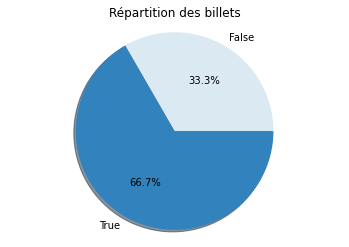

In [75]:
# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(Billet_df.groupby(["is_genuine"])["diagonal"].count(),
        labels=["False","True"],
        autopct="%1.1f%%",
        colors=["#dbe9f3","#3182bd"],
        shadow=True)
ax1.axis("equal")
plt.title("Répartition des billets")
plt.show()

#On compte n'importe quelle dimension pour le graphique (ici "diagonal") puisqu'elles sont toutes presentes une fois sur chaques billets.

In [76]:
Billet_df['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

On a 1000 vrais billets et 500 faux billets de banque.

In [77]:
Billet_df.groupby('is_genuine').mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90116,104.19034,104.14362,5.216137,3.35016,111.63064
True,171.98708,103.94913,103.80865,4.116312,3.05213,113.20243


Plus de 1 mm de différence entre vrai et faux billets sur la moyenne des marges basses et la longueur.

## Analyse bivariées

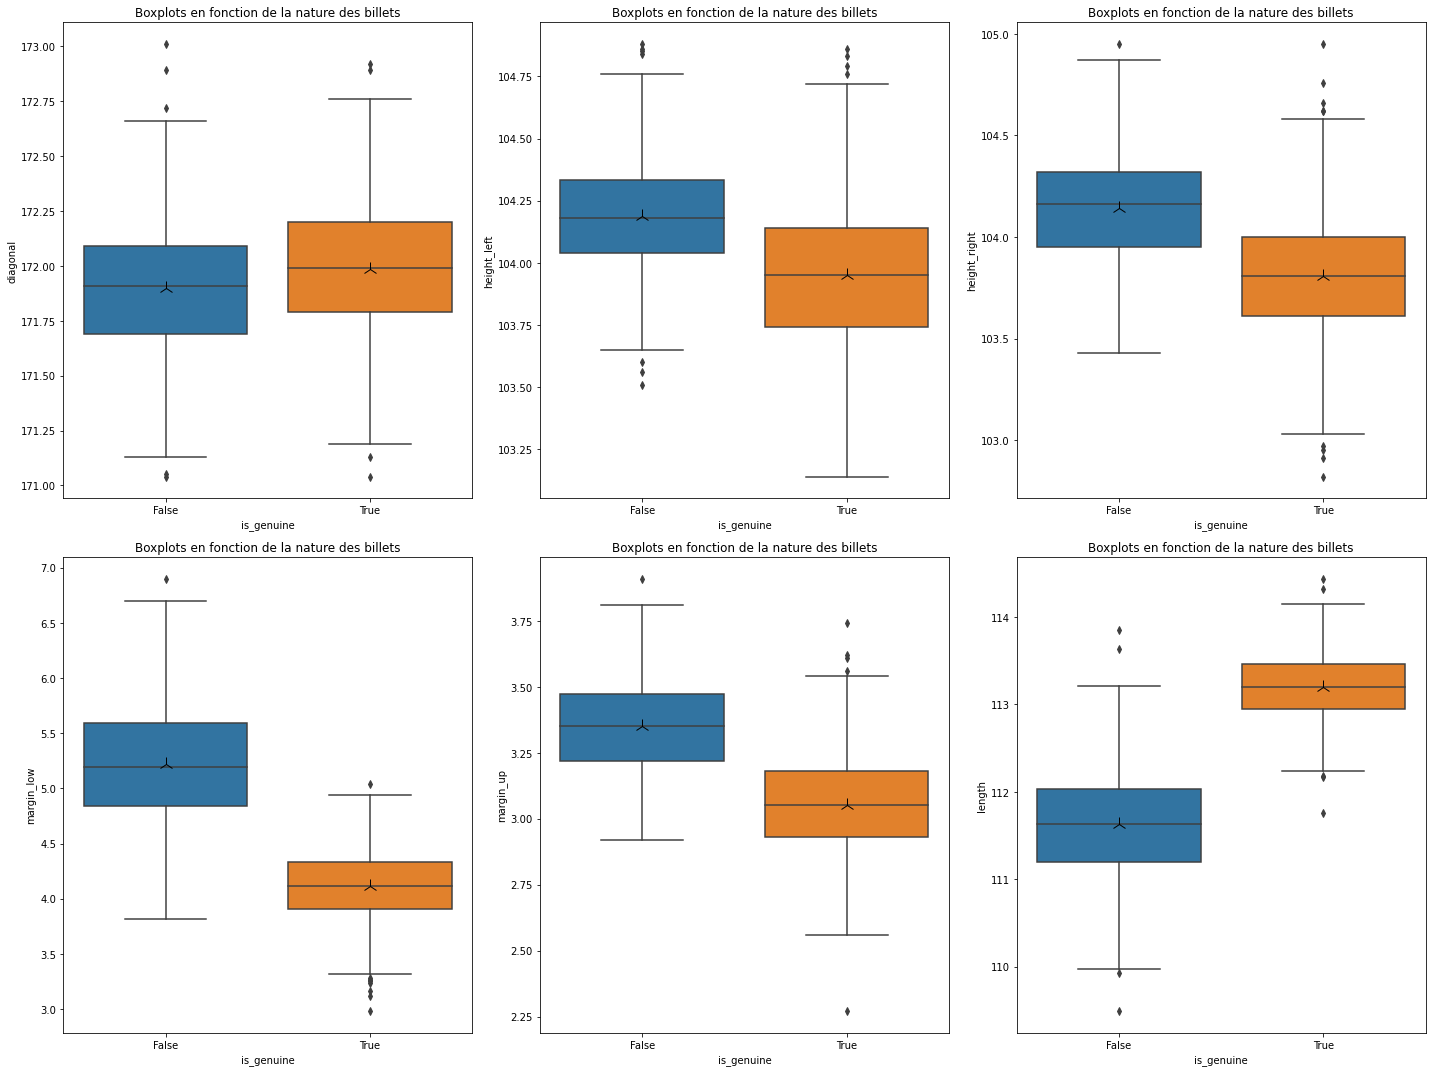

In [78]:
#Boxplot
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
fig_name = "Boxplots en fonction de la nature des billets"
meanprops = {"marker":"2","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"15"}

for count, col in enumerate(Billet_df.columns[Billet_df.columns!='is_genuine']):
    if count < 3 :
        sns.boxplot(data=Billet_df, y=col, x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[0,count])
        ax[0,count].title.set_text(fig_name)
    else :
        sns.boxplot(data=Billet_df, y=col, x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[1,count-3]) 
        ax[1,count-3].title.set_text(fig_name)
   
plt.tight_layout()
plt.show()

#### Lecture des résultats :

- La diagonale des vrais et faux billets sont assez proches, leur moyenne est presque égale.

- La hauteur, côté gauche des vrais billets est dans l'ensemble plus petite, avec un écart assez élevé, présence de plusieurs outliers dans les vrais comme dans les faux billets.

- La hauteur du côté droit est dans l'ensemble plus petite avec un écart assez grand et présence de plusieurs outliers dans les vrais billets.

- La marge du bord inférieur est plus petite sur les vrais billets, la moyenne des faux billets est supérieur au vrai billet.

- La marge supérieure des vrais billets est dans l'ensemble plus basse mais avec un grand écart avec la présence de plusieurs outliers.

- La longueur des  vrais billets est plus grande avec un faible écart, la moyenne des faux billets est inférieur à la valeur la plus faible des vrais billets.

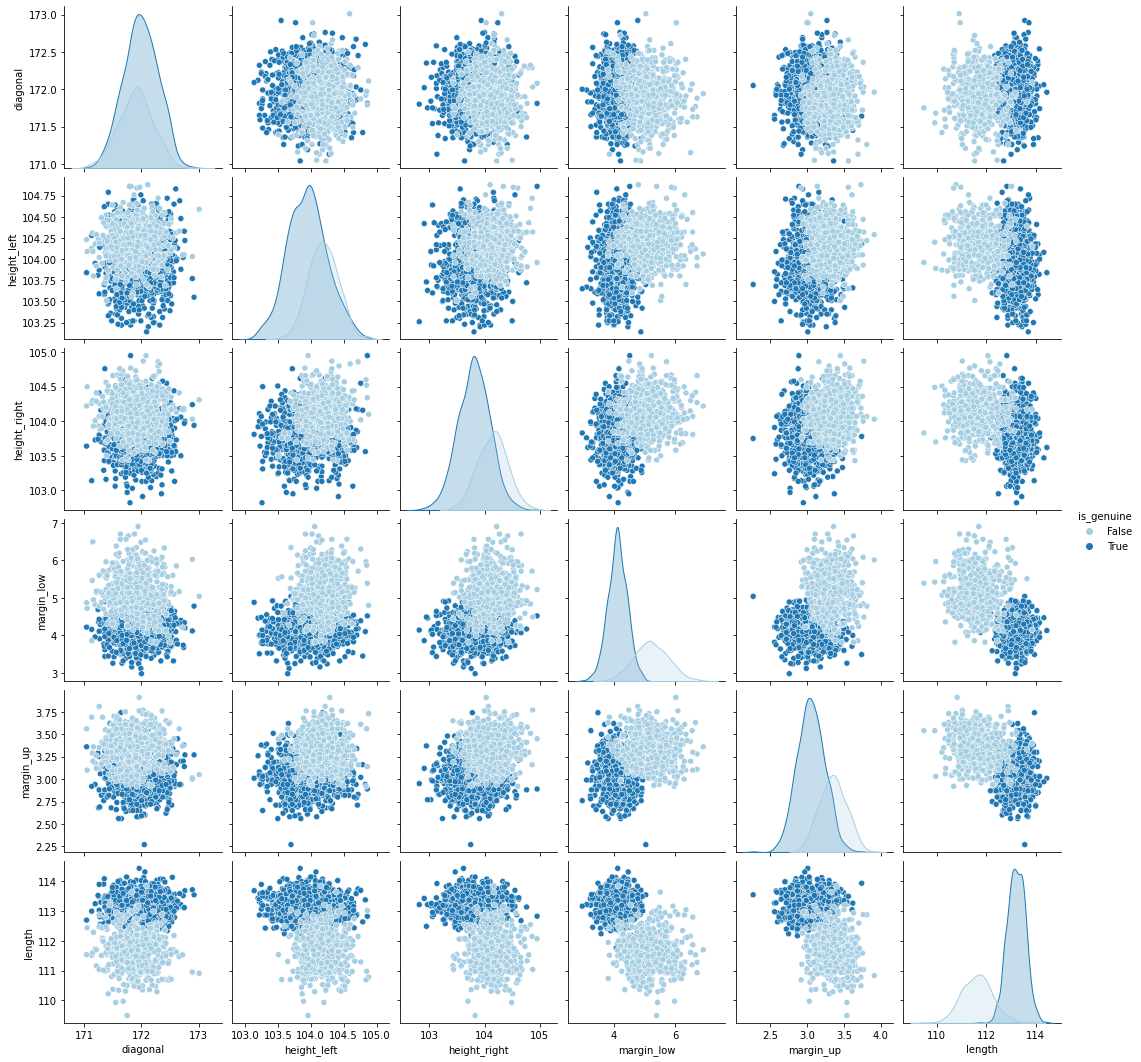

In [79]:
# Pair plot:
sns.pairplot(Billet_df, hue="is_genuine", palette="Paired")

"lengh" et "margin_low" sont les dimenssions qui distinguent le plus les billets trues des falses d'après les nuages de point et les courbes.

# Prédiction de l'authenticité des billets
Pour la mise en palce d'un modele capable de prédire au mieux si un billet et vrai ou faux, nous allons tester plusieurs méthodes :

- K-Means
- LogisticRegression
- Knn

## Standardisation des variables 
Permet de neutraliser les différences dues à des variables influençant le phénomène étudié  On réalise donc un centrage et une réduction. Qui nous servira par la suite pour nos méthodes de classifications.

In [80]:
df_acp = Billet_df.drop(['is_genuine'], axis=1)
X = df_acp.values
names = df_acp.index

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
df_norm = pd.DataFrame(X_scaled, columns=df_acp.columns)

In [81]:
df_norm.head() # Les données sont bien normalisées, on peut donc faire une analyse par composantes principales.

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.056219,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.080917,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.125723,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.308345,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.671548,1.417677,-0.158750


## ACP

On réalise une analyse en composantes principales pour réduire les 6 variables et représenter nos billets dans un espace à 2 dismensions. On pourra ainsi observer les clusters et avoir 2 variables synthétiques.

In [82]:
# choix du nombre de composantes à calculer
n_comp = 6

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

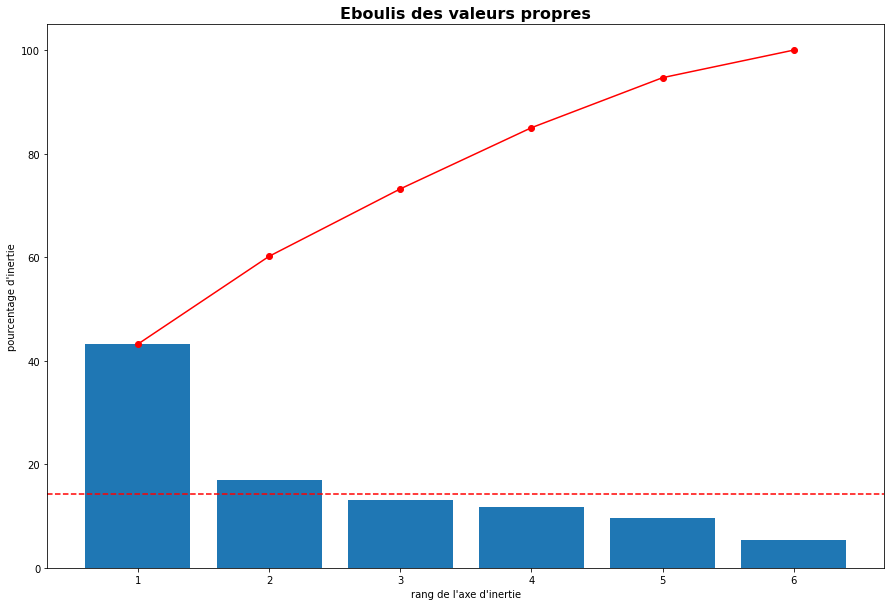

                                     1          2          3          4  \
Cumul de variance expliquée  43.203583  60.160803  73.180884  85.006072   

                                     5      6  
Cumul de variance expliquée  94.673459  100.0  


In [83]:
display_scree_plot(pca)

Etant donnée que nous avons 6 variables, le seuil a prendre en considération est de 16.7% (kaiser=100/6). Nous analyserons donc seulement les variables F1 et F2 qui réprésentent 60,2% de l'inertie totale.

Les 4 autres variables représentent chacune moins de 15% de l'inertie totale, soit moins que notre seuil.

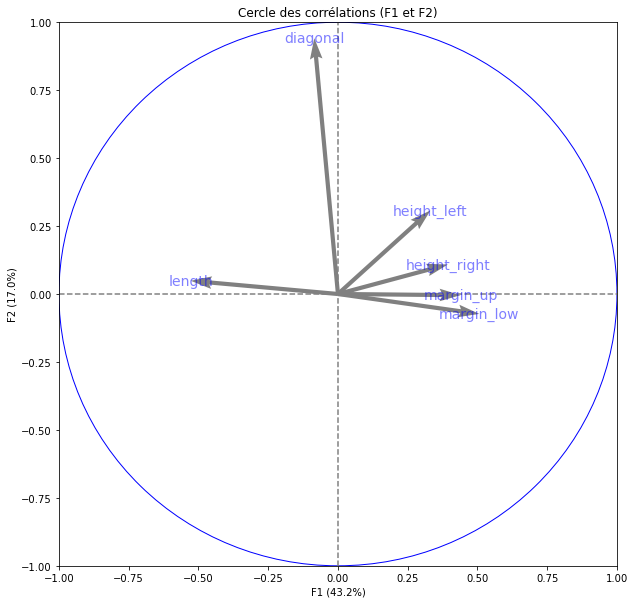

In [84]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(df_norm.columns))

La composante F1 représente 43% de l'inertie totale.
Les variables qui seraient corrélées (positivement) sont la hauteur et les marges :
- height_left
- height_right
- margin_up
- margin_low
Elles sont anticorrélées avec la longueur des billets (lenght). 
Plus la valeur F2 est grande, plus le billet est petit en hauteur et l'image centrée.

La composante F2 représente 17% de l'inertie totale. Elle est corrélée à la longueur de la diagonale.

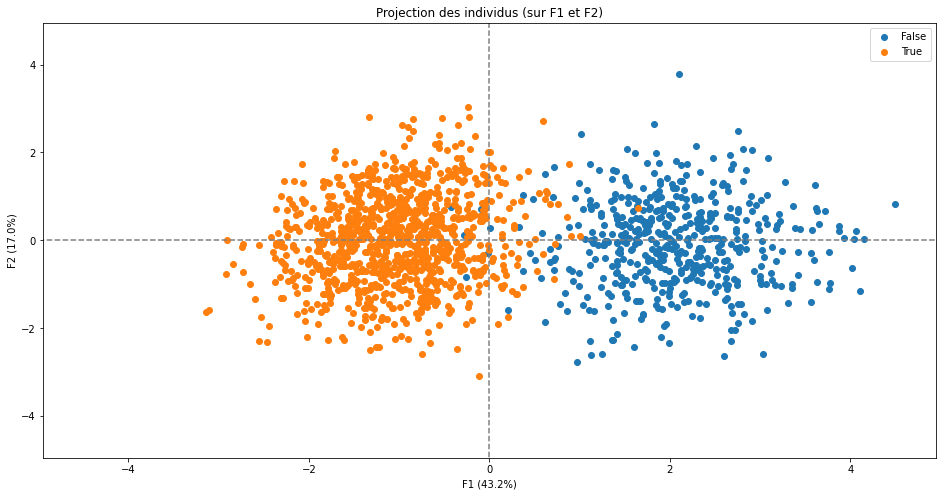

In [85]:
# Projection des individus sur le premier plan factoriel :
df_norm["is_genuine"] = billet_df["is_genuine"]
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = df_norm["is_genuine"])
plt.show()

On observe deux nuages de points qui se distinguent sur la composante F1. Les vrais billets se situent sur une partie gauche de la projection. L'authenticité des billets semble être corrélée par la composantes F1.

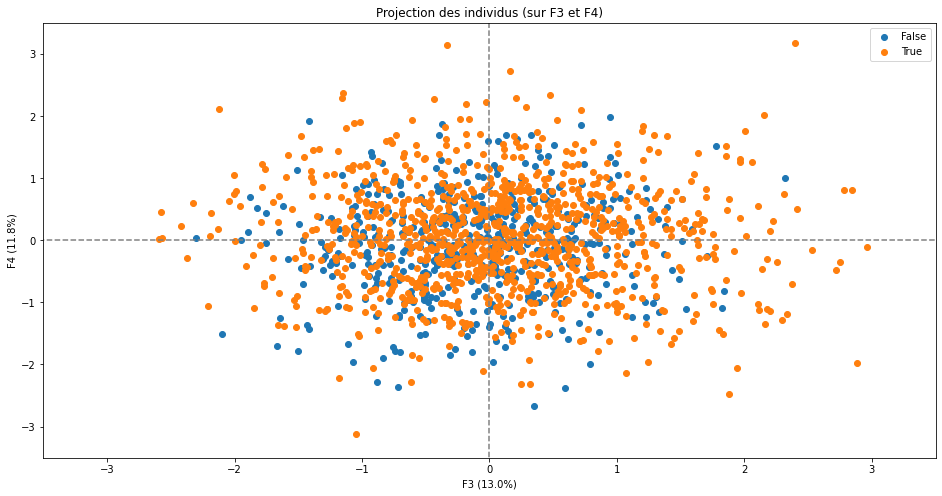

In [86]:
display_factorial_planes(X_projected, n_comp, pca, [(2,3)], illustrative_var = df_norm["is_genuine"])
plt.show()

Comme vu plus haut, la disctinction de l'authenticité des billets par rapport aux composantes F3 et F4 ne semble par être possible. Les nuages de points se confondent.
On interprétre donc seulement la projection des individus dans le premier plan factoriel.

Conclusion :

On distingue bien deux clusters sur la projection, l'un pour les vrai billets et l'autre pour les faux billets. Ils sont caractérisés particulierrement par la composantes F1.

Les billets valides auraient par rapport aux faux billets :

- une plus petite hauteur
- un longueur plus grande
- la diagonale ne permettrait pas de distinguer les 2 types de billets.

In [87]:
#df_class = Billet_df.copy()

In [88]:
#reduced = pca.fit_transform(X_scaled)

#for i in range(0, n_comp): 
    #df_class['PC' + str(i + 1)] = reduced[:, i]
#df_class

## Echantillonage

Dans les données et du point de vu de nos modèles, nous avons donc :

- 1500 observations
- 7 attribus prédictives
- 1 variable cible à 2 modalités

Création des datasets :

On cherche ici à échantilloner nos données pour que l'apprentissage soit moins lourd. Cet échantillon est représentatif de toutes les données.

Le training set :
Il va nous permettre d’entraîner nos modèles et sera utilisé par l’algorithme d’apprentissage.

Le testing set :
Il permet de mesurer l’erreur du modèle final sur des données tests. On va mesurer la performance des modèles sur ces données.

Les modèles seront complètement optimisés pour les données à l'aide desquelles ils ont été créés. L'erreur sera minimal sur ces données. Elle sera toujours plus élevée sur des données que le modèle n'aura jamais vues. Pour minimiser ce problème, la meilleure approche est de séparer dès le départ notre jeu de données en deux parties distinctes.

On décide d'échantillonner comme suit :

80 % pour le training set
20 % pour le testing set.

In [89]:
from sklearn.model_selection import train_test_split

feature_cols = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_norm[feature_cols]
y = df_norm['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [90]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1200, 6)

(300, 6)

(1200,)

(300,)

# Méthode des K Means

La méthode des K-Means permet tout d'abord de déterminer 2 clusters parmis les individus correspondant aux vrais et faux billets. On détermine ensuite pour chacun des billets du jeu de donnée test, le groupe auquel il appartient.

### Implémentation et prédiction

In [91]:
# Nombre de clusters souhaités :  2 puisque l'on a 2 modalités pour la variable is_genuine.
n_clust = 2

# Clustering par K-means
modele_kmeans = cluster.KMeans(n_clusters=n_clust)
class_modele_kmeans = modele_kmeans.fit(X_train)

# Récupération des clusters attribués à chaque individu
k_means_clusters = class_modele_kmeans.labels_

df_K_means = pd.DataFrame(k_means_clusters)

y_pred_kmean = modele_kmeans.predict(X_test)

### Calcul des centroïde

In [92]:
# choix du nombre de composantes à calculer
n_comp = 2

# Calcul des composantes principales
pca2 = decomposition.PCA(n_components=n_comp)
pca2.fit(X_train)
X_scaled_projected_2 = pca2.transform(X_train)

In [93]:
centroids = class_modele_kmeans.cluster_centers_
centroids_projected = pca2.transform(centroids)

/Users/lepeltier.c/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


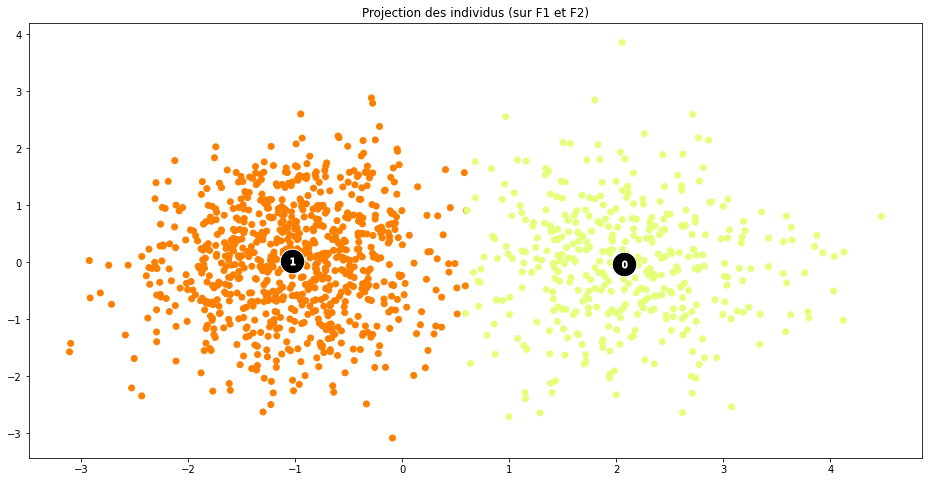

In [94]:
# Visualisations des centroïdes sur le 1er plan factoriel de l'ACP :
plt.figure(figsize=(16,8))
plt.scatter(X_scaled_projected_2[:, 0], X_scaled_projected_2[:, 1], c=k_means_clusters, cmap = 'Wistia')

plt.scatter(centroids_projected[:, 0], centroids_projected[:, 1], marker='o',
                c="black", alpha=1, s=600, edgecolor='w')
for i, c in enumerate(centroids_projected):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='w')
        
plt.title("Projection des individus (sur F1 et F2)")
plt.show(block=False)

Avec l'algorithme des K-means, nous observons deux clusters, l'un pour les vrais billets et l'autre pour les faux billets.

### Matrice de confusion

Une matrice de confusion est utilisée pour évaluer la performance d'un modèle de classification. La matrice compare les valeurs cibles réelles avec celles prédites par le modèle d'apprentissage machine. Cela nous donne une vue d'ensemble des performances de notre modèle de classification et des types d'erreurs qu'il commet.

<AxesSubplot:xlabel='Predicted values', ylabel='Actual values'>

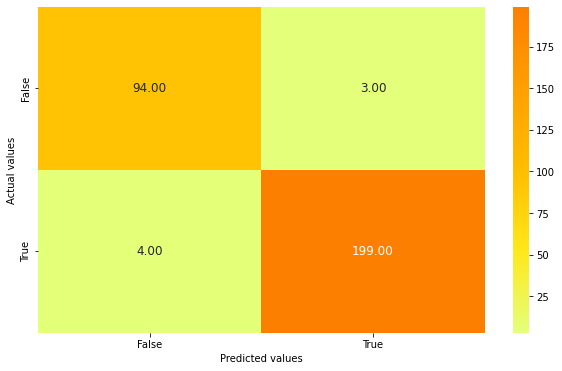

In [95]:
# Détermination des clusters True et False
valeurs_uniques, compte_des_valeurs_uniques = np.unique(y_pred_kmean, return_counts=True)

# On renomme les clusters
cluster_true = [
    index for index in valeurs_uniques if compte_des_valeurs_uniques[index] == max(compte_des_valeurs_uniques)]
cluster_false = [
    index for index in valeurs_uniques if compte_des_valeurs_uniques[index] != max(compte_des_valeurs_uniques)]

dict = {True: cluster_true, False: cluster_false}
y_test.replace(dict)

cnf_matrix = pd.crosstab(y_test, y_pred_kmean, rownames=['Actual values'], colnames=['Predicted values'])

cnf_matrix=cnf_matrix.rename(columns = {cluster_true[0]:'True'})
cnf_matrix=cnf_matrix.rename(columns = {cluster_false[0]:'False'})

plt.figure(figsize=(10,6))
sns.heatmap(cnf_matrix, cmap='Wistia',annot_kws = {'fontsize': 12},fmt = '.2f',annot=True)

In [96]:
y_pred_kmean_list = []

for x in y_pred_kmean:
    if x == cluster_true[0] :
        y_pred_kmean_list.append(True)
    else:
        y_pred_kmean_list.append(False)

print(metrics.classification_report(y_test, y_pred_kmean_list))

              precision    recall  f1-score   support

       False       0.96      0.97      0.96        97
        True       0.99      0.98      0.98       203

    accuracy                           0.98       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.98      0.98      0.98       300



Notre modèle est quasiment parfait puisque tous les scores s'approchent de 1.

Accuracy :  la proportion de points correctement prédits. Accuracy = TP+TN/total

Precision : c’est-à-dire la proportion de prédictions correctes parmi les points que l’on a prédits positifs. Precision = TP/TP+FP

Recall : Le rappel, ou sensibilité ("sensitivity" en anglais), est le taux de vrais positifs, c’est à dire la proportion de positifs que l’on a correctement identifiés.  Recall = TP/TP+FN

F1 score - c'est une moyenne pondérée de la sensibilité et de la spécificité. On prend donc en compte les faux positifs et les faux négatifs en compte. Ce score, bien que moins intuitif que la précision est plus juste en particuliers pour les jeux de données dissymétriques. F1 Score = 2(Recall Precision) / (Recall + Precision)

Les deux clusters sont bien corrélés aux authenticité des billets. On note toutefois des billets faux positifs et faux négatifs.

# Méthode de régression logistique classique

### Implémentation du modele

In [97]:
# DataFrame Train
billet_base = pd.DataFrame(data = X_train.copy(), index=X_train.index, columns=X_train.columns)
billet_base['is_genuine'] = y_train
billet_base['is_genuine'] = billet_base['is_genuine'].map({True:1, False:0})

In [98]:
billet_base

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
620,-0.289878,-2.102918,-0.308144,-0.641225,-0.912562,0.391431,1
655,0.431212,0.101772,-0.062383,-0.777681,0.727236,0.471666,1
319,0.300105,0.268794,0.674903,0.374618,-1.818766,0.712371,1
140,1.676733,-0.699933,-1.014709,-0.959623,-1.646156,0.563363,1
629,0.168997,0.001559,-0.768948,-0.883814,0.123100,-0.078516,1
...,...,...,...,...,...,...,...
763,1.480071,1.337734,-0.830388,-0.777681,0.856694,1.182318,1
835,0.627873,0.168581,0.552022,-0.216693,-1.603003,0.746757,1
1216,-0.093217,0.201985,1.811551,0.586883,1.849203,-1.201803,0
559,0.529543,-1.468234,-0.461745,-1.126403,0.252558,0.735295,1


In [99]:
# On utilise la fonction my_backward_selected_logistic afin de trouvers les variables descriptives les plus pertinentes
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
reg_backward_log = my_backward_selected_logistic(billet_base[columns], 'is_genuine')

_______________________________
is_genuine ~ length + margin_low + height_right + height_left + diagonal + margin_up + 1
Optimization terminated successfully.
         Current function value: 0.029654
         Iterations 11
remove diagonal (p-value: 0.75 )

_______________________________
is_genuine ~ length + margin_low + height_right + height_left + margin_up + 1
Optimization terminated successfully.
         Current function value: 0.029696
         Iterations 11
remove height_left (p-value: 0.181 )

_______________________________
is_genuine ~ length + margin_low + height_right + margin_up + 1
Optimization terminated successfully.
         Current function value: 0.030469
         Iterations 11
is the final model!

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1195
Method:                           

Pour notre modele, les variables descriptives significatives sont les suivantes :
- height_right
- length
- margin_low
- margin_up

Avec un Pseudo R-Square à 0,9523 ce qui signifie que le model explique une grande partie de la variation dans la variable de réponse "is_genuine".

In [100]:
# On affecte à nos X et y les données nécessaires en retirant les variables descriptives non significatives
feature_cols2 = ['height_right', 'margin_low', 'margin_up', 'length']
X2 = df_norm[feature_cols2]
y2 = df_norm['is_genuine']

In [101]:
# On définit notre Train Set et notre Test Set
X2_train ,X2_test, y2_train, y2_test = train_test_split(X2,y2, train_size=0.8, random_state=0)

In [102]:
# On définit notre model
model_reg_log = LogisticRegression()

# On entraine notre model
model_reg_log = model_reg_log.fit(X2_train, y2_train)

In [103]:
print("Training score:", round(model_reg_log.score(X2_train, y2_train), 5))

Training score: 0.98917


### Evaluation du modele

En régression logistique, on ne peut pas évaluer les résidus directement, car leur distribution n'est pas normale (car la variable dépendante est binaire).
Tracer les résidus de Pearson studentisés ou les résidus de déviance, par rapport aux valeurs prédites linéaires avec un lissage de Lowess, peut constituer un élément de diagnostic du modèle de régression logistique.

Si les tracés se rapprochent de la ligne horizontale avec 0 intercept, cela suggère qu'il n'y a pas d'insuffisance significative du modèle.

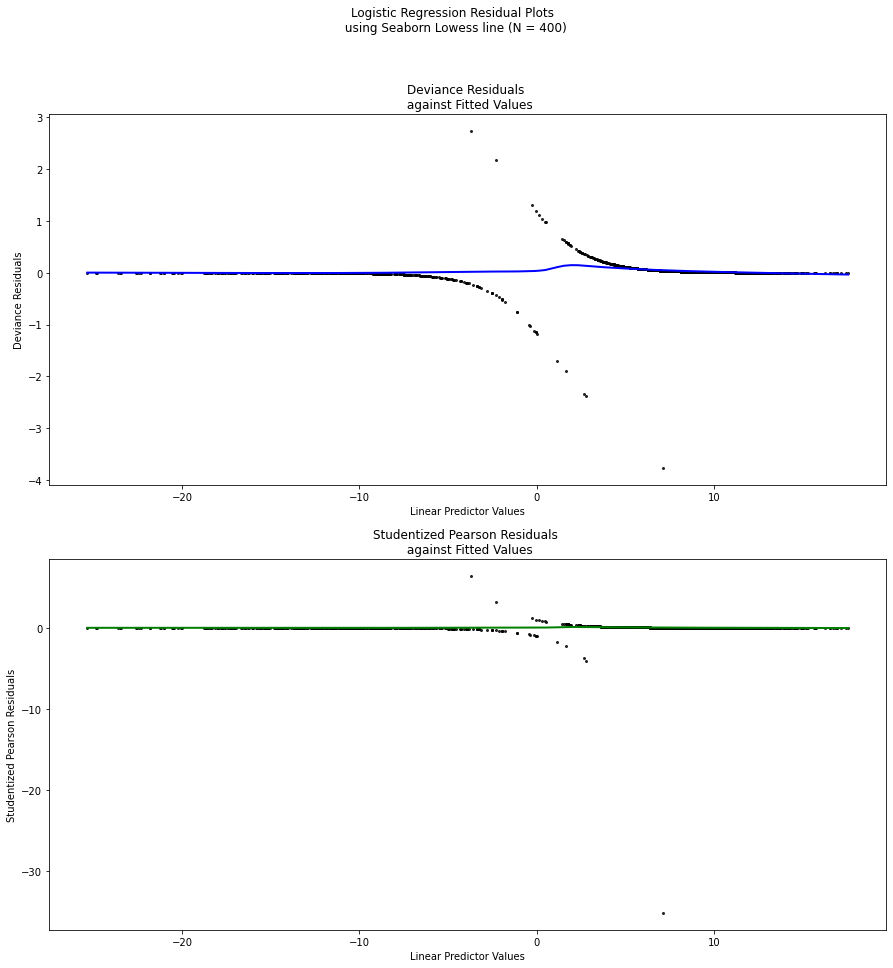

In [104]:
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(x=reg_backward_log.fittedvalues, y=reg_backward_log.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 4},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(x=reg_backward_log.fittedvalues, y=reg_backward_log.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 4},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

### Predictions

In [105]:
# On enregistre les prédictions des données test dans une variable y_pred
y_pred_reg_log = model_reg_log.predict(X2_test)

### Courbe de ROC
Permet de derterminer et comparer les performances diagnostic de plusieurs tests à l'aide l'évaluation des aires sous la courbe.

In [106]:
fpr, tpr, _ = metrics.roc_curve(y2_test, y_pred_reg_log)

In [107]:
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.9948453608247423


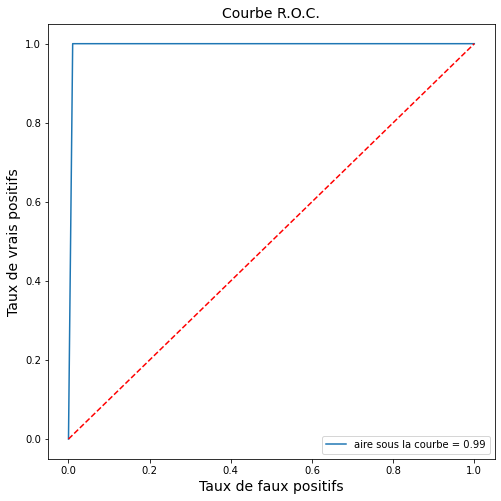

In [108]:
# Graphique
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(fpr,tpr,label="aire sous la courbe = %0.2f" % roc_auc)
plt.plot([0,1],[0,1],"r--")
plt.legend(loc=4)
plt.title('Courbe R.O.C.', fontsize=14)
ax.set_ylabel('Taux de vrais positifs', fontsize=14)
ax.set_xlabel('Taux de faux positifs', fontsize=14)
plt.show()

On observe alors un AUC (area under curve) proche de 1.

### Score sur les training set et testing set :

In [109]:
print("Training score:", round(model_reg_log.score(X2_train, y2_train), 5))
print("Testing score:", round(model_reg_log.score(X2_test, y2_test), 5))

Training score: 0.98917
Testing score: 0.99667


Le modèle donne de bons scores proche de 1 sur les deux jeux de données. On peut en déduire que le modèle est bien calibré.

### Matrice de confusion :

<AxesSubplot:xlabel='Predicted values', ylabel='Actual values'>

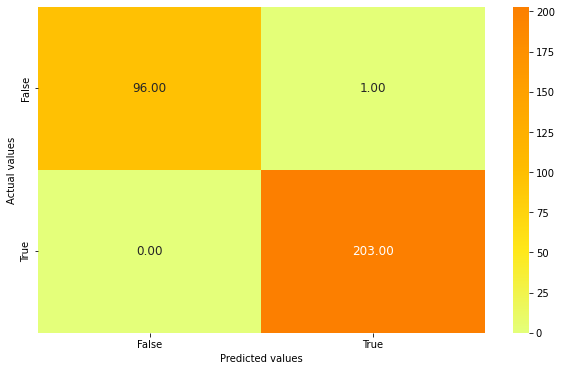

In [110]:
cnf_matrix2 = pd.crosstab(y2_test, y_pred_reg_log, rownames=['Actual values'], colnames=['Predicted values'])
plt.figure(figsize=(10,6))
sns.heatmap(cnf_matrix2, cmap='Wistia',annot_kws = {'fontsize': 12},fmt = '.2f', annot=True)

In [111]:
print(metrics.classification_report(y2_test, y_pred_reg_log))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99        97
        True       1.00      1.00      1.00       203

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



La méthode de régression logistique affiche un score de précision presque parfait et un faux positifs. 

# Méthode des k Nearest Neighbors
L'algorithme (plus proches voisins) consiste à choisir les k données les plus proches du point étudié afin d’en prédire sa valeur. Il se base uniquement sur les données d’entraînement. Toutes les données d'entraînement sont concervées en mémoire (memory-based) et il convient donc aux problèmes d'assez petite taille.

### Implémentation et prédictions

In [112]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

### Evaluation du modele

In [113]:
#Score de precision
print("Training score:", round(knn.score(X_train, y_train), 5))
print("Testing score:", round(knn.score(X_test, y_test), 5))

Training score: 0.99417
Testing score: 0.97


In [114]:
### Matrice de confusion

<AxesSubplot:xlabel='Predicted values', ylabel='Actual values'>

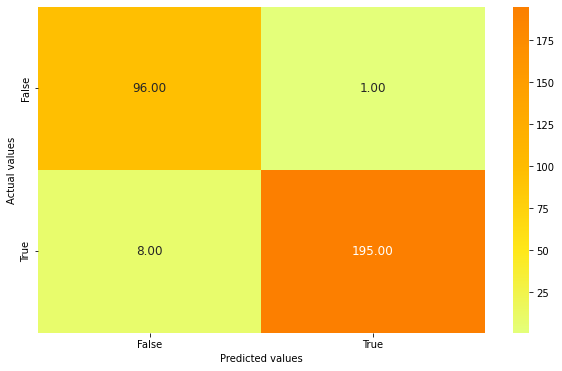

In [115]:
cnf_matrix3 = pd.crosstab(y_test, y_pred_knn, rownames=['Actual values'], colnames=['Predicted values'])
plt.figure(figsize=(10,6))
sns.heatmap(cnf_matrix3,cmap='Wistia',annot_kws = {'fontsize': 12},fmt = '.2f', annot=True)

In [116]:
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

       False       0.92      0.99      0.96        97
        True       0.99      0.96      0.98       203

    accuracy                           0.97       300
   macro avg       0.96      0.98      0.97       300
weighted avg       0.97      0.97      0.97       300



C'est la méthode qui affiche le plus petit score des méthodes que l'on a essayé plus haut. La prédiction reste cependant bonne avec un taux de réussite de 97%.

# Conclusion

In [117]:
print(f"""
Score régression logistique classique : {round(metrics.f1_score(y2_test, y_pred_reg_log), 3)}
Score méthode des k-means             : {round(metrics.f1_score(y_test, y_pred_kmean_list), 3)}
Score méthode des k Nearest Neighbors : {round(metrics.f1_score(y_test, y_pred_knn), 3)}
""")


Score régression logistique classique : 0.998
Score méthode des k-means             : 0.983
Score méthode des k Nearest Neighbors : 0.977



Nous devions mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets. Pour nos prédictions, nous avons essayé plusieurs méthodes d'apprentissage parmis lesquels des méthode de régression et de classification. On a pu comparer le taux de précisions de ces dernières.

Le K_means ne prend pas en compte la variable is_genuine, il ne fait que regrouper les valeurs proches entre elles. Notre échantillon de billets est donc sensible au clustering, mais cette methode n'est pas forcement pertinente pour predir si un billet est vrai/faux. Sur un autre échantillon de billet le resultat peut etre radicalement différent. La regression elle, predit la variable is_genuine en fonction des autres et "apprend", le modèle est aussi améliorable et plus pertinent comme modèle predictif.

Pour notre programme de détection, on décide de choisir la méthode de régression logistique qui offre un score plus élevé.

# Création Algorithme Modèle prédictif

Algorithme = Suite d'Instruction, methode systematique de proceder afin d'obtenir un résultat :
  
1 - Choix des variable du df à standardiser  
2 - Standardisation  
3 - Calcul probabilité_false grace à la regression logistique model_reg_log sur les dimensions : height_right+margin_low+margin_up+height_left  
4 - Mise en forme et création d'une nouvelle variable proba_is_false  
5 - Calcul de la prediction y (True/False)  
6 - Création de la variable is_genuine  
7 - Affichage des resultats (df + 1 colonne avec la probabilité false et 1 colonne affectation de la nature du billet)    


Voici notre fonction prediction à appliquer :

In [118]:
def billet_predict_logreg(df):
    X = df[["height_right", "margin_low", "margin_up", "length"]]
    X_scaled = preprocessing.StandardScaler().fit_transform(X)
    proba_false = model_reg_log.predict_proba(X_scaled)[:, 0]
    proba_false = [round(num, 5) for num in proba_false]
    df['proba_is_false'] = proba_false
    y = model_reg_log.predict(X_scaled)
    df['is_genuine'] = y
    return df

In [123]:
# Importer le jeu de données test
df_test = pd.read_csv('billets_test.csv', sep =',', decimal=".", header=0)

In [124]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
 6   id            5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 408.0+ bytes


In [125]:
df_test.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


## Vérification du modèle sur l'échantillon de test

In [126]:
billet_predict_logreg(df_test)

/Users/lepeltier.c/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/lepeltier.c/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_is_false,is_genuine
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,0.00005,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0.87688,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,0.00004,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,0.99985,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0.54794,False


Nous avons bien une colonne qui affiche la probabilité du billet d'etre faux ainsi qu'une colonne pour la prediction de sa nature (true/false).